# Big Data Analytics Evaluation

HJ: I'll tidy this up later to package into a function to call based on different files...

In [18]:
%matplotlib inline
import pandas as pd, numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix

### Reading Data
Data files and result files are without headers and index.

In [19]:
# pred = pd.read_csv("../result/first-CommonNeighbours(10).csv", header=None)

# Common Neighbours
cm10 = pd.read_csv("../result/CommonNeighbours(10).csv", header=None)
cm7 = pd.read_csv("../result/CommonNeighbours(7).csv", header=None)
cm5 = pd.read_csv("../result/CommonNeighbours(5).csv", header=None)
# Adamic Adar
aa05 = pd.read_csv("../result/AdamicAdar(0.5).csv", header=None)
aa3 = pd.read_csv("../result/AdamicAdar(3).csv", header=None)
aa6 = pd.read_csv("../result/AdamicAdar(6).csv", header=None)
aa12 = pd.read_csv("../result/AdamicAdar(12).csv", header=None)
# Jaccard Similarity
jc3 = pd.read_csv("../result/JaccardSim(3).csv", header=None)
jc5 = pd.read_csv("../result/JaccardSim(5).csv", header=None)
jc7 = pd.read_csv("../result/JaccardSim(7).csv", header=None)
# QSF (active only)
QFS10 = pd.read_csv("../result/QFS(10).csv", header=None)
QFS1 = pd.read_csv("../result/QFS(1)_active.csv", header=None)

actual_active = pd.read_csv("../result/actual_active.csv", header=None)
actual = pd.read_csv("../data/second_nodate.csv", header=None)
full = pd.read_csv("../data/twitter.csv")

Add any new models below

In [20]:
models = [cm5, cm7, cm10, aa3, aa6, aa12, jc3, jc5, jc7]
model_names = ['CommonNeighbours(5)', 'CommonNeighbours(7)', 'CommonNeighbours(10)', 'AdamicAdar(3)', 'AdamicAdar(6)', 'AdamicAdar(12)', 'JaccardSim(3)', 'JaccardSim(5)', 'JaccardSim(7)']

## Baseline statistics

In [21]:
# Random probability chance of predicting
actual_no = len(actual)
print("Number of actual edges formed: " + str(actual_no))
num_all_possibilities = len(full['Source'].unique())*(len(full['Source'].unique())-1)
rand_prob = len(actual)/num_all_possibilities
print("Random probability chance of predicting edge: " + str(rand_prob))

Number of actual edges formed: 25530
Random probability chance of predicting edge: 3.7111374882618704e-06


## CalculatingAccuracy

### Cleaning and Formatting data
To allow for merging. Prediction file has brackets from graphx/sparkling-graph, actual file doesn't

In [22]:
# Cleaning actual
for col in actual.columns:
    actual[col] = actual[col].apply(str)
    
actual['edge'] = '(' + actual[0].astype(str) + ',' + actual[1].astype(str) + ')'

In [23]:
# # Cleaning prediction
# for col in pred.columns:
#     pred[col] = pred[col].apply(str)
    
# pred['edge'] = pred[0].astype(str) + ',' + pred[1].astype(str)
# correct = pd.merge(actual, pred, on=['edge'])

In [24]:
# P = len(actual)
# # Below are all positives. 
# TP = len(correct)
# FN = P - TP  # misclassified positives

# N = num_all_possibilities - P
# # Below are all negatives
# FP = len(pred) - len(correct)
# TN = N - FP

In [25]:
# recall = TP/P
# precision = TP/(TP+FP)
# print("Recall: " + str(recall))
# print("Precision: " + str(precision))
# f1score = (precision*recall)/(precision+recall)
# print("F1-score: " + str(f1score))

In [26]:
def clean_prediction(pred):
    for col in pred.columns:
        pred[col] = pred[col].apply(str)
        pred['edge'] = pred[0].astype(str) + ',' + pred[1].astype(str)
    return

def merge_prediction(pred, actual):
    
    # Cleaning actual
    for col in actual.columns:
        actual[col] = actual[col].apply(str)

    actual['edge'] = '(' + actual[0].astype(str) + ',' + actual[1].astype(str) + ')'
    correct = pd.merge(actual, pred, on=['edge'])
    return correct

### Calculating values for confusion matrix

In [27]:
def calculate_counts(actual, pred, correct):
    P = len(actual)
    # Below are all positives. 
    TP = len(correct)
    FN = P - TP  # misclassified positives

    N = num_all_possibilities - P
    # Below are all negatives
    FP = len(pred) - len(correct)
    TN = N - FP
    return [TP, FP, TN, FN]

def calculate_metrics(counts):
    TP, FP, TN, FN = counts
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return (recall, precision, accuracy)

In [28]:
def get_score(sample_pred, actual):
    pred = sample_pred
    clean_prediction(pred)
    correct = merge_prediction(pred, actual)
#     print("Total number of predicted edges: " + str(len(pred)))
#     print("Number of correct predicted edges: " + str(len(correct)))
#     print("Total number of actual edges: " + str(len(actual)))
#     print("Recall: " + str(len(correct)/len(actual)))
    counts = calculate_counts(actual, pred, correct)
    recall, precision, accuracy = calculate_metrics(counts)
    return (recall, precision, accuracy)

In [29]:
get_score(cm5, actual)

(0.033490011750881316, 0.00904063527645311, 0.9999827899451372)

## Metrics

In [30]:
def get_confusion_matrix(sample_pred, actual, model_name, log_scale=False):
    pred = sample_pred
    clean_prediction(pred)
    correct = merge_prediction(pred, actual)
#     print("Total number of predicted edges: " + str(len(pred)))
#     print("Number of correct predicted edges: " + str(len(correct)))
#     print("Total number of actual edges: " + str(len(actual)))
#     print("Recall: " + str(len(correct)/len(actual)))
    [TP, FP, TN, FN] = calculate_counts(actual, pred, correct)
    array = [[TP, FP], [TN, FN]]
    conf_matrix = pd.DataFrame(array, columns=['True', 'False'], index=['Positive', 'Negative'])
    plt.figure()
    if log_scale:
        from math import log
        logged = conf_matrix.applymap(lambda x: log(x, 10))
        sns.heatmap(logged, annot=True, cmap="Blues").set_title("Confusion matrix (log10 scale) - " + model_name)
    else:
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f").set_title("Confusion Matrix - " + model_name)
    

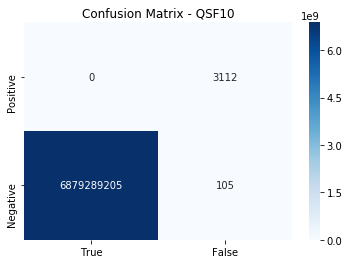

In [31]:
get_confusion_matrix(QFS10, actual_active, 'QSF10')

### Iterating to get all model results in a dataframe

In [32]:
recall_scores = []
precision_scores = []
accuracy_scores = []

for model in models:
    recall, precision, accuracy = get_score(model, actual)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)

In [33]:
results = pd.DataFrame(index = model_names)
results['Precision'] = precision_scores
results['Recall'] = recall_scores
results['F1 score'] = 2*(results['Precision']*results['Recall'])/(results['Precision']+results['Recall'])
results['Accuracy'] = accuracy_scores
results

,Precision,Recall,F1 score,Accuracy
CommonNeighbours(5),0.009041,0.033490,0.014238,0.999983
CommonNeighbours(7),0.009396,0.020055,0.012797,0.999989
CommonNeighbours(10),0.008762,0.009871,0.009283,0.999992
AdamicAdar(3),0.003307,0.018919,0.005630,0.999975
AdamicAdar(6),0.001559,0.005680,0.002446,0.999983
AdamicAdar(12),0.001246,0.004074,0.001908,0.999984
JaccardSim(3),0.002728,0.027340,0.004962,0.999959
JaccardSim(5),0.001543,0.004348,0.002277,0.999986
JaccardSim(7),0.000608,0.001371,0.000842,0.999988


## Plotting Confusion Matrix

### Models with full dataset

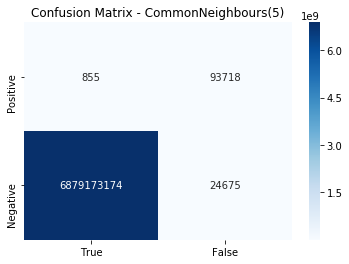

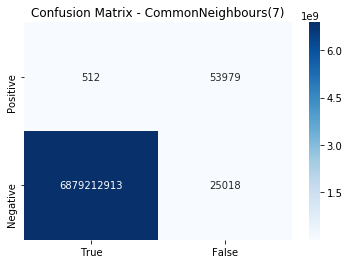

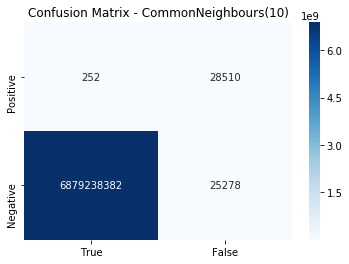

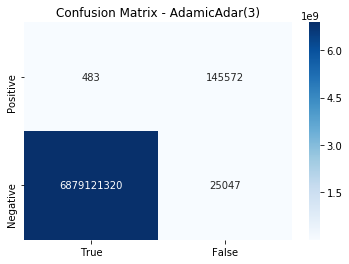

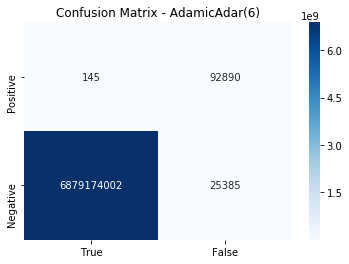

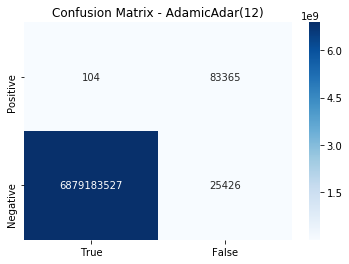

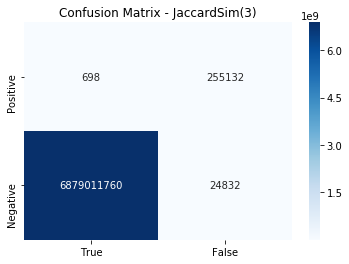

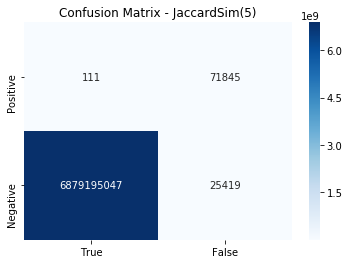

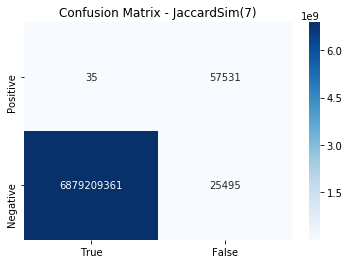

In [34]:
for i, model in enumerate(models):
    get_confusion_matrix(model, actual, model_names[i])

### Models with only active users

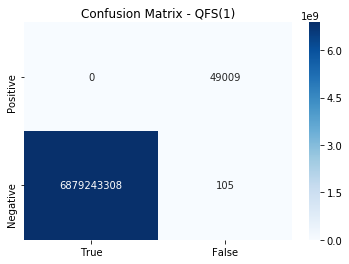

In [38]:
get_confusion_matrix(QFS1, actual_active, 'QFS(1)')